In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import interpolate

### Zvolení druhu konečného prvku, nainicializování bodů a vah Gaussovy-Legendreovy kvadratury

In [2]:
n = 9 # kvadraticke prvky (QUAD9) (4 vrcholy + 5 midpointu)

line_o3_QP = np.array([-np.sqrt(3/5), 0, np.sqrt(3/5)], dtype=np.float64)
line_o3_QW = np.array([5/9, 8/9, 5/9], dtype=np.float64)
tmp = np.ones(shape=line_o3_QW.shape, dtype=np.float64)
quad_o3_QP = np.vstack((np.kron(tmp, line_o3_QP), np.kron(line_o3_QP, tmp))) # Gaussovy body
quad_o3_QW = np.kron(line_o3_QW, line_o3_QW) # vahy

nqp = quad_o3_QP.shape[1] # celkovy pocet pouzitych Gaussovych bodu

### Definice kvadratických násadových funkcí a jejich derivací na příslušném referenčním prvku

In [3]:
def quad9_N(rs: np.ndarray) -> np.ndarray:

    return np.vstack(((-0.5*(1-rs[0, :])*rs[0, :])*(-0.5*(1-rs[1, :])*rs[1, :]),
                      ((1-rs[0, :])*(1+rs[0, :]))*(-0.5*(1-rs[1, :])*rs[1, :]),
                      (0.5*(1+rs[0, :])*rs[0, :])*(-0.5*(1-rs[1, :])*rs[1, :]),
                      (-0.5*(1-rs[0, :])*rs[0, :])*((1-rs[1, :])*(1+rs[1, :])),
                      ((1-rs[0, :])*(1+rs[0, :]))*((1-rs[1, :])*(1+rs[1, :])),
                      (0.5*(1+rs[0, :])*rs[0, :])*((1-rs[1, :])*(1+rs[1, :])),
                      (-0.5*(1-rs[0, :])*rs[0, :])*(0.5*(1+rs[1, :])*rs[1, :]),
                      ((1-rs[0, :])*(1+rs[0, :]))*(0.5*(1+rs[1, :])*rs[1, :]),
                      (0.5*(1+rs[0, :])*rs[0, :])*(0.5*(1+rs[1, :])*rs[1, :])))

def quad9_dNdxi(rs: np.ndarray) -> np.ndarray:

    return np.vstack((np.hstack(((-0.5+rs[0, :])*(-0.5*(1-rs[1, :])*rs[1, :]), (-0.5*(1-rs[0, :])*rs[0, :])*(-0.5+rs[1, :]))),
                      np.hstack(((-2*rs[0, :])*(-0.5*(1-rs[1, :])*rs[1, :]), ((1-rs[0, :])*(1+rs[0, :]))*(-0.5+rs[1, :]))),
                      np.hstack(((0.5+rs[0, :])*(-0.5*(1-rs[1, :])*rs[1, :]), (0.5*(1+rs[0, :])*rs[0, :])*(-0.5+rs[1, :]))),
                      np.hstack(((-0.5+rs[0, :])*((1-rs[1, :])*(1+rs[1, :])), (-0.5*(1-rs[0, :])*rs[0, :])*(-2*rs[1, :]))),
                      np.hstack(((-2*rs[0, :])*((1-rs[1, :])*(1+rs[1, :])), ((1-rs[0, :])*(1+rs[0, :]))*(-2*rs[1, :]))),
                      np.hstack(((0.5+rs[0, :])*((1-rs[1, :])*(1+rs[1, :])), (0.5*(1+rs[0, :])*rs[0, :])*(-2*rs[1, :]))),
                      np.hstack(((-0.5+rs[0, :])*(0.5*(1+rs[1, :])*rs[1, :]), (-0.5*(1-rs[0, :])*rs[0, :])*(0.5+rs[1, :]))),
                      np.hstack(((-2*rs[0, :])*(0.5*(1+rs[1, :])*rs[1, :]), ((1-rs[0, :])*(1+rs[0, :]))*(0.5+rs[1, :]))),
                      np.hstack(((0.5+rs[0, :])*(0.5*(1+rs[1, :])*rs[1, :]), (0.5*(1+rs[0, :])*rs[0, :])*(0.5+rs[1, :])))))

### Výpočet hodnot násadových funkcí a hodnot jejich derivací v bodech Gaussovy-Legendreovy kvadratury

In [4]:
quad_o3_QP_N = quad9_N(quad_o3_QP)

tmp = quad9_dNdxi(quad_o3_QP)
dNdxi = np.zeros(shape=(nqp, n, 2), dtype=np.float64)
dNdxi[:, :, 0] = tmp[:, 0:nqp].T
dNdxi[:, :, 1] = tmp[:, nqp:2*nqp].T

### Dekompozice výpočetní oblasti na konečné prvky

In [5]:
# Deklarace a definice pomocne funkce

def bspl_surf_mpts(n_x: int, n_y: int):
    knt_xi = np.array([0, 0, 0, 3, 3, 3], dtype=np.float64)
    knt_eta = np.array([0, 0, 0, 4, 4, 4], dtype=np.float64)

    ctrlpts = np.array([[0.0, 0.0], [2.0, 0.0], [4.0, 0.0],
                        [0.0, 7.0], [2.0, 5.0], [4.0, 3.0],
                        [7.0, 7.0], [7.0, 5.0], [7.0, 3.0],], dtype=np.float64)
    
    bspl_basis_xi = []
    c_xi = np.zeros(shape=3, dtype=np.float64)
    for i in range(3):
        bspl_basis_xi.append(interpolate.BSpline(knt_xi, c_xi, 2, extrapolate=False))

    bspl_basis_eta = []
    c_eta = np.zeros(shape=3, dtype=np.float64)
    for i in range(3):
        bspl_basis_eta.append(interpolate.BSpline(knt_eta, c_eta, 2, extrapolate=False))

    xixi, etaeta = np.meshgrid(np.linspace(0, 3, n_x), np.linspace(0, 4, n_y))
    xx = np.zeros(shape=xixi.shape, dtype=np.float64)
    yy = np.zeros(shape=etaeta.shape, dtype=np.float64)
    for i in range(3):
        c_eta[i] = 1
        for j in range(3):
            c_xi[j] = 1
            xx += ctrlpts[3*i + j, 0]*bspl_basis_xi[j](xixi)*bspl_basis_eta[i](etaeta)
            yy += ctrlpts[3*i + j, 1]*bspl_basis_xi[j](xixi)*bspl_basis_eta[i](etaeta)
            c_xi[j] = 0
        c_eta[i] = 0

    return xx, yy

In [6]:
N = np.array([4, 5])
ne = np.prod(N - 1) # pocet pouzitych konecnych prvku
nn = np.prod(N + N - 1) # pocet uzlovych bodu (a nasadovych funkci)

ind = np.zeros(shape=(N[1] + N[1] - 1, N[0] + N[0] - 1), dtype=np.int64) # matice globalnich indexu
ind[:, :] = np.reshape([i for i in range(0, nn)], newshape=(N[1] + N[1] - 1, N[0] + N[0] - 1))
mesh_ele = np.column_stack((np.reshape(ind[0:-2:2, 0:-2:2], newshape=ne),
                            np.reshape(ind[0:-2:2, 1:-1:2], newshape=ne),
                            np.reshape(ind[0:-2:2, 2::2], newshape=ne),
                            np.reshape(ind[1:-1:2, 0:-2:2], newshape=ne),
                            np.reshape(ind[1:-1:2, 1:-1:2], newshape=ne),
                            np.reshape(ind[1:-1:2, 2::2], newshape=ne),
                            np.reshape(ind[2::2, 0:-2:2], newshape=ne),
                            np.reshape(ind[2::2, 1:-1:2], newshape=ne),
                            np.reshape(ind[2::2, 2::2], newshape=ne))) # matice urcujici vztah mezi lokalnimi (na jednom konecnem prvku)
                                                                       # a globalnimi indexy uzlovych bodu (a nasadovych funkci) (zobrazeni l2g)
xx, yy = bspl_surf_mpts(N[0] + N[0] - 1, N[1] + N[1] - 1)
mesh_coo = np.column_stack((np.reshape(xx, newshape=nn), np.reshape(yy, newshape=nn))) # uzlove body

### Sestavení matice tuhosti a vektoru zatížení

In [7]:
K = np.zeros(shape=(nn, nn), dtype=np.float64)

for e in range(ne):
    ele_e = mesh_ele[e, :]

    P = mesh_coo[ele_e, :]
    P3D = np.zeros(shape=(nqp, n, 2), dtype=np.float64)
    P3D[:, :, :] = P

    J = P3D.transpose(0, 2, 1) @ dNdxi # hodnoty jakobianu zobrazeni Z^e v Gaussovych bodech

    detJ = J[:, 0, 0]*J[:, 1, 1] - J[:, 0, 1]*J[:, 1, 0] # hodnoty determinantu jakobianu zobrazeni Z^e v Gaussovych bodech
    absdetJ = np.abs(detJ)

    invJ = np.zeros(shape=(nqp, 2, 2), dtype=np.float64) # hodnoty inverze jakobianu zobrazeni Z^e v Gaussovych bodech
    invJ[:, 0, 0] =  J[:, 1, 1]/detJ                     # (pomoci Cramerova pravidla)
    invJ[:, 0, 1] = -J[:, 0, 1]/detJ
    invJ[:, 1, 0] = -J[:, 1, 0]/detJ
    invJ[:, 1, 1] =  J[:, 0, 0]/detJ

    dNdX = dNdxi @ invJ

    tmp = np.reshape((dNdX @ dNdX.transpose(0, 2, 1)).transpose(2, 1, 0), newshape=(n*n, nqp)) # lokalni matice tuhosti
    Kloc_flattened = tmp @ (absdetJ*quad_o3_QW)

    tmp = np.ones(shape=n, dtype=np.int64)
    K_ind_i = np.kron(tmp, ele_e)
    K_ind_j = np.kron(ele_e, tmp)
    K[K_ind_i, K_ind_j] += Kloc_flattened

f = np.zeros(shape=nn, dtype=np.float64)

print(np.linalg.norm(K @ np.ones(shape=nn))) # test

3.9257600972984166e-15


### Zahrnutí Dirichletovy okrajové podmínky, sestavení a vyřešení příslušné soustavy

In [8]:
nnd = 28 # pocet nasadovych funkci majicich nenulovou stopu na Gamma_D
ind_d = np.hstack((ind[0, :], ind[1:-1, 0], ind[1:-1, -1], ind[-1, :])) # globalni indexy nasadovych funkci majicich nenulovou stopu na Gamma_D

g = np.zeros(shape=nnd, dtype=np.float64)
g[0:7] = -(1/8)*(mesh_coo[0:7, 0]**2) + 3
g[7:14] = 3
g[14:-7] = 1
g[-7:] = -(1/8)*(mesh_coo[0:7, 0]**2) + 3

B = np.zeros(shape=(nnd, nn), dtype=np.float64)
B[[ i for i in range(nnd) ], ind_d] = 1

A = np.zeros(shape=(nn + nnd, nn + nnd), dtype=np.float64)
A[0:nn, 0:nn] = K
A[nn:, 0:nn] = B
A[0:nn, nn:] = B.T

b = np.zeros(shape=(nn + nnd), dtype=np.float64)
b[0:nn] = f
b[nn:] = g

fem_sol_c = np.linalg.solve(A, b)[0:nn]

### Vykreslení přibližného řešení

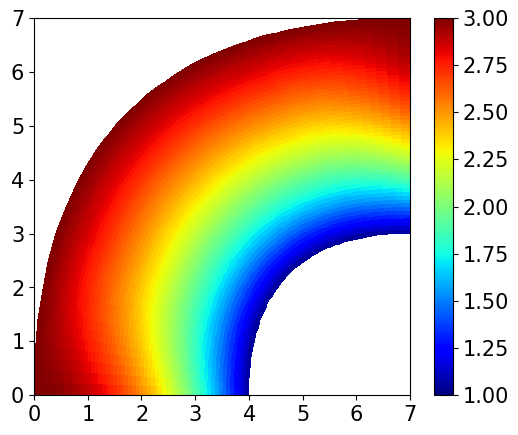

In [9]:
plot_mesh_refele_xixi, plot_mesh_refele_etaeta = np.meshgrid(np.linspace(-1, 1, 20), np.linspace(-1, 1, 15))

plot_mesh_xx = np.zeros(shape=(57, 58), dtype=np.float64)
plot_mesh_yy = np.zeros(shape=(57, 58), dtype=np.float64)
plot_mesh_v = np.zeros(shape=(57, 58), dtype=np.float64)

mesh_ele_ind = np.vstack((np.kron(np.ones(shape=4, dtype=np.int64), np.array([0, 1, 2], dtype=np.int64)),
                          np.kron(np.array([0, 1, 2, 3], dtype=np.int64), np.ones(shape=3, dtype=np.int64))))

for e in range(ne):
    ele_e = mesh_ele[e, :]
    ele_e_midx = mesh_ele_ind[:, e]

    P_e = mesh_coo[ele_e, :]
    plot_mesh_xx_e = np.zeros(shape=(15, 20), dtype=np.float64)
    plot_mesh_yy_e = np.zeros(shape=(15, 20), dtype=np.float64)
    for i in range(15):
        tmp = quad9_N(np.vstack((plot_mesh_refele_xixi[i, :], plot_mesh_refele_etaeta[i, :])))
        plot_mesh_xx_e[i, :] = tmp.T @ P_e[:, 0]
        plot_mesh_yy_e[i, :] = tmp.T @ P_e[:, 1]
    plot_mesh_xx[(ele_e_midx[1]*15) - ele_e_midx[1]:(ele_e_midx[1]*15) - ele_e_midx[1] + 15,
                 (ele_e_midx[0]*20) - ele_e_midx[0]:(ele_e_midx[0]*20) - ele_e_midx[0] + 20] = plot_mesh_xx_e
    plot_mesh_yy[(ele_e_midx[1]*15) - ele_e_midx[1]:(ele_e_midx[1]*15) - ele_e_midx[1] + 15,
                 (ele_e_midx[0]*20) - ele_e_midx[0]:(ele_e_midx[0]*20) - ele_e_midx[0] + 20] = plot_mesh_yy_e
    
    c_e = fem_sol_c[ele_e]
    plot_mesh_v_e = np.zeros(shape=(15, 20), dtype=np.float64)
    for i in range(15):
        tmp = quad9_N(np.vstack((plot_mesh_refele_xixi[i, :], plot_mesh_refele_etaeta[i, :])))
        plot_mesh_v_e[i, :] = tmp.T @ c_e
    plot_mesh_v[(ele_e_midx[1]*15) - ele_e_midx[1]:(ele_e_midx[1]*15) - ele_e_midx[1] + 15,
                (ele_e_midx[0]*20) - ele_e_midx[0]:(ele_e_midx[0]*20) - ele_e_midx[0] + 20] = plot_mesh_v_e
    
fig, ax = plt.subplots(figsize=(6.07, 4.9))
cmesh = ax.pcolormesh(plot_mesh_xx, plot_mesh_yy, plot_mesh_v[:-1, :-1], cmap='jet', vmin=np.min(plot_mesh_v), vmax=np.max(plot_mesh_v))
cbar = fig.colorbar(cmesh)

ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7])
ax.set_xticklabels([r'$0$', r'$1$', r'$2$', r'$3$', r'$4$', r'$5$', r'$6$', r'$7$'], fontsize=15)
ax.set_yticks([0, 1, 2, 3, 4, 5, 6, 7])
ax.set_yticklabels([r'$0$', r'$1$', r'$2$', r'$3$', r'$4$', r'$5$', r'$6$', r'$7$'], fontsize=15)

cbar.ax.tick_params(labelsize=15)

plt.show()